In [25]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations

In [26]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [27]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [ ]:
play_df.shape

In [ ]:
play_df.loc[play_df['num_routes'] == 0]

In [ ]:
tracking_df.loc[(tracking_df['gameId'] == 2018090600) & (tracking_df['playId'] == 776)]

In [ ]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [ ]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [ ]:
# Attempt clustering of play data

In [ ]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns).drop(['gameId', 'playId'], axis=1)

In [ ]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(df_scaled)

In [ ]:
distortions = []
num_plays = 15

for i in range(1, num_plays + 1):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(df_scaled)
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow method for Optimal K')
plt.show()

In [ ]:
range_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for i in range_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_scaled)
    cluster_labels = km.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

plt.plot(range_clusters, silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for Optimal K')
plt.show()

In [ ]:
limit = 0.0000001
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=limit,
                                n_clusters=None)
model.fit(df_scaled)
df['cluster'] = model.labels_

In [ ]:
range_clusters = []
n_samples = df_scaled.shape[0]
[range_clusters.append(x) for x in range(2, 21)]
silhouette_avg = []

for i in range_clusters:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=i)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_clusters, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
plt.show()

In [ ]:
df['cluster']

In [ ]:
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=8)
model.fit(df_scaled)

In [ ]:
df_scaled['cluster'] = model.labels_
print(df_scaled['cluster'].value_counts())

In [ ]:
print(df['cluster'].value_counts())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10000, max_depth=10)
clf.fit(df[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']], df['cluster'])

In [ ]:
clf.feature_importances_

In [ ]:
clf.score(df_scaled[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']], df_scaled['cluster'])

In [ ]:
clf.feature_importances_

In [ ]:
plt.figure(figsize=(15, 10))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(clf.feature_names_in_[sorted_idx], clf.feature_importances_[sorted_idx])

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
perm_imp = permutation_importance(clf, df[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']], df['cluster'])

In [ ]:
plt.figure(figsize=(15, 10))
sorted_idx = perm_imp.importances_mean.argsort()
plt.barh(clf.feature_names_in_[sorted_idx], perm_imp.importances_mean[sorted_idx])

In [ ]:
range_limit = []
[range_limit.append(n) for n in np.linspace(5*10**-7, 5*10**-8, 10)]
print(range_limit)
silhouette_avg = []
n_clusters = []
for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    n_clusters.append(len(np.unique(model.labels_)))

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_limit, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
ax2 = ax.twinx()
ax2.plot(range_limit, n_clusters, color='r')
ax2.set_ylabel('Number of clusters')
plt.show()

In [ ]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

In [ ]:
cluster6 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 6)]
cluster6.mean().apply(lambda x: '%.5f' % x)

In [ ]:
df.head()

In [ ]:
df.groupby('cluster')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

In [ ]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

In [ ]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box()

In [ ]:
df.groupby('cluster')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box()

In [ ]:
cluster0 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 0)]
cluster0.mean().apply(lambda x: '%.5f' % x)

In [ ]:
cluster2 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 2)]
cluster2.mean().apply(lambda x: '%.5f' % x)

In [ ]:
cluster0.columns

In [ ]:
plt.boxplot(cluster0[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()
plt.boxplot(cluster2[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()

In [ ]:
verticals = df.loc[(df['GO'] == 4)]
sorted(verticals['cluster'].unique().tolist())

In [ ]:
flood = df.loc[(df['CORNER'] == 1) & (df['OUT'] == 1) & (df['FLAT'] == 1) & (df['POST'] == 1)]
sorted(flood['cluster'].unique().tolist())

In [ ]:
slants = df.loc[(df['SLANT'] >= 2)]
sorted(slants['cluster'].unique().tolist())

In [ ]:
def plot_relationship(df, xcol, ycol, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        left=True,
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    x = df[xcol]
    y = df[ycol]
    main_ax.scatter(x, y, c=labels)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()
    x_hist.set_xlabel(xcol)

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    y_hist.set_ylabel(ycol)

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
plot_relationship(df, df_columns[0], df_columns[1], model.labels_)

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], model.labels_)

In [ ]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_a_presnap']
y = df_scaled['offense_a_to_throw']
z = df_scaled['offense_a_to_arrived']
ax.scatter3D(x, y, z, c=model.labels_)

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], model.labels_)

In [ ]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_a_presnap']
y = df_scaled['offense_a_to_throw']
z = df_scaled['offense_a_to_arrived']
ax.scatter3D(x, y, z, c=model.labels_)

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], model.labels_)

(array([70.,  0.,  0., 36.,  0.,  0., 13.,  0.,  0.,  4.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

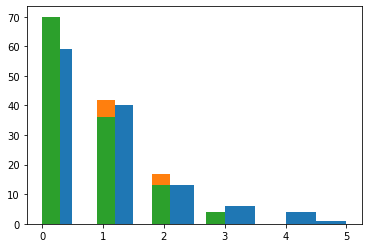

In [132]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_a_presnap']
y = df_scaled['offense_a_to_throw']
z = df_scaled['offense_a_to_arrived']
ax.scatter3D(x, y, z, c=model.labels_)